<center><h1> Lab05 102062207 Regressor</h1></center>



# General Description
This notebook will be divided into 3 parts, each part will be corresponded to one of the three question given in the this assigment, and each part will also be broke into several subsection in order to clarify my code and thoughts. 

Now, we will walk through the whole assignment in the following order:
* Implementation of LassoRegressor
* Tune & Train the LassoRegressor
* Feature Selection and XRegressor

# Part I. Implementation of LassoRegressor

The LassoRegressor is a type of regressor that deal with the regression problem by solving the cost function:
$$\arg\min_{\boldsymbol{w}\in\mathbb{R}^{D},b}\frac{1}{2N}\Vert\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}-b\boldsymbol{1})\Vert^{2}+\alpha\Vert\boldsymbol{w}\Vert_{1},$$
 
Where $\alpha$ is a constant that will determine how much the **1-norm** term will influence the cost function, and the term $N$ is the number of samples that used to train the regressor.

To lower the result of the cost function above, one frequently used method is **gradient descent**:
$$x^{(t+1)}=x^{(t)}-\eta g$$
Where t is the t-th iteration, $\eta$ is learning rate, or stepsize, and $g$ is the gradient. By solving this equation iteratively, we can reach a **local optimum point** with a proper **stepsize**.


Since we need to compute gradient, we have to apply **partial differentiation** to the cost function. However, one may found that is that the **1-norm** term might be **non-differentiable** at some points. This phenomenon will cause a big problem when we are training the regressor because that we want to use gradient descent method to train, but **we cannot obtain a gradient from a non-differentiable point.**

To cope with that annoying non-differentialble problem, I choose **subgradient method** as a method to tackle the problem.

### Subgradient Method
The idea of subgradient method is simple :
* When the point is differentialble, we just simply compute the gradient
* If it's not differentiable, we randomly assign a value $[-1, 1]$ to it, as a **subgradient** and use it to do the descent task.

However, a **negative subgradient may to point to a descent direction.** Some constraint have to be imposed on it to make sure that our algorithm will descent.

Thus, I impose the following constraint to the subgradient:
$$\eta=\frac{f(x_k) - f^{lev}_{k}}{\Vert s_k\Vert ^2}$$

Where $\eta$ is a **modified** learning rate, $s_k$ is a subgradient, $f(x_k)$ is the cost function at iteration $k$, and $f^{lev}_{k}=\min_{0\leq i\leq k}f(x_{i})$.

This constraint can be simply interpreted as the description below:
* If the regressor is converged to some point, the  $\eta$ will be closed or equal to $0$.
  - that is, when the regressor is closed to some local optimum points, it shouldn't take a big step size. This can prevent it from leaving the local optimum point since it has limited effect on the descent direction .
* If the regressor is far from some points with low cost, the $\eta$ will increase.
  - that is, since you are not closed to any local optimum, you can take a big step.
  
By applying this constraint, we can make sure that the non-differential point won't drag the descent direction away from local optimum point, and thus the whole process will descent.

In [2]:
%matplotlib inline

### Implementation

Now let's take a look at my implementation.
The comments in the code below will explain the details of my implementation.

In [3]:
from pylab import *
from copy import deepcopy

In [4]:
class LassoRegressor(object):
    
    def __init__(self, eta=0.001, alpha=0.001, n_iter=40, random_state=1, zero=1e-10):
        """ Initialize LassoRegressor.
        
        Parameters
        ----------
        eta : float
              Learing rate.
        alpha : float
              The coefficient of the 1-norm term in the cost function
        n_iter : int
              Numbers of iteration.
        random_state : int
              Random seed.
        zero : float
              Value that smaller than zero will be considered as zero.
        """
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.zero = zero
        self.random_state = random_state
        
    def fit(self, X, y, stop_crit=1e+15):
        """ Fit the model with given traning set.
        
        Parameters
        ----------
        X : ndarray
            Training data.
        y : ndarray
            Label of training data.
        stop_crit : float
            If the result of cost function exceeds this value,
            the training process will be stop since it cannot
            converge.
        
        Returns
        -------
        self :
               Trained model.
        """
        
        # First, we initialize the weights with random value.
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        N = X.shape[0]
        

        # After initializing the weights, we start iterating to
        # solve the cost function. The self.w_[0] indicates the
        # intercept/bias of the function, so we don't need to 
        # do gradient descent on it.
        for i in range(self.n_iter):
            output = self.predict(X)
            # this term is equal to :
            # y - (Xw - b1)
            errors = (y - output)
            L1_norm = np.fabs(self.w_[1:]).sum()
            
            # calculate the "SSE" term.
            # This is equal to the gradient of
            # (1/2N)||y - (Wx - b1)||^2
            SSE = self.eta * X.T.dot(errors) / N

            # subgradient_descent_ will help us get
            # the gradient of a||w||_1.
            # You can see the detailed explanation in
            # its function defintion.
            L1_sub = self.subgradient_descent_()
            
            # update weights.
            # the reason why 'SSE' we add SSE to weights instead
            # of subtracting is that the partial derivative term
            # will have a negative sign. So the updating rule:
            # x(t+1) = x(t) - g(x) = x(t) - (-eta*(y-(Wx-b)))
            #        = x(t) + (eta*(y-(Wx-b)))
            # and the term 'L1_sub' do not have a negative sign,
            # so it's still a subtrahend.
            self.w_[1:] += SSE - L1_sub
            
            # update bias by simply adding the errors to i.
            self.w_[0] += self.eta * errors.sum()
            
            # update the cost 
            cost = (errors**2).sum() / (2.0 * N) + self.alpha * L1_norm
            self.cost_.append(cost)
        
            # stop if the errors exceed stop criteria.
            if errors.sum() > stop_crit:
                print("Error! Sum of errors exceeds stop criteria")
                break
        return self
    
    def subgradient_descent_(self):
        """ Computing the gradient for the differential point in 1-norm
            as well as the subgradient for the non-differetiable point.
        """
        # the derivative of 1-norm will be 1 or -1 according
        # to its sign. 
        # (ex. -5 will have a derivative 1, while 0.5 will have 1.)
        subgrad = np.sign(self.w_[1:])
        n_eta = deepcopy(self.eta)
        
        # The 1-norm is non-differetiable when the value is equal
        # to 0. Find this point by using np. operation
        non_diff = (np.fabs(self.w_[1:]) <= self.zero)
        can_diff = np.logical_not(non_diff)

        if len(non_diff[non_diff == True]) > 0:
            
            subgrad[non_diff] = np.random.uniform(-1, 1)
            
            # apply the constraint to it.
            # but we have to make sure we already have costs first.
            if len(self.cost_) > 0:
                
                # get f(x_k), and find the minimum cost in the previous
                # cost results.
                cost = self.cost_[-1]
                min_cost = min(self.cost_)
                
                # adjust the learning rate.
                # if the current cost is equal to the minimum one,
                # then the subgradient won't influence the descent direction;
                # otherwise, it will change the direction and stepsize based
                # on the difference between cost and min_cost.
                n_eta = (cost - min_cost) / ((np.fabs(subgrad).sum())**2)
                
        # apply different learning rate to gradient and subgradient
        subgrad[non_diff] *= n_eta
        subgrad[can_diff] *= self.eta
        
        # multiply alpha
        subgrad *= self.alpha

        return subgrad
    
    def predict(self, X):
        """ Predict the regression result of X by solving
            y = w0 + w0x0 + w1x1 ... + wnxn
        """
        return np.dot(X, self.w_[1:]) + self.w_[0]

Now, we need to make sure that our LassoRegressor can have the **tendency of convergence**.

We test it by using small $\eta$ and $\alpha$, and a very small iterations number:

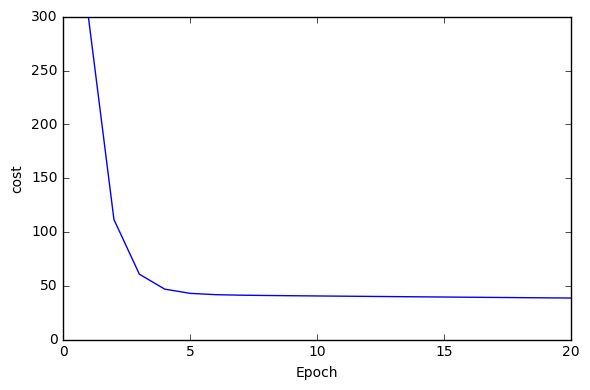

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso


train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

sc_x = StandardScaler()
X_std = sc_x.fit_transform(train_set)
#y_train_std = sc_y.fit_transform(y_train)

llr = LassoRegressor(eta=0.001,alpha=0.001, n_iter=20)
llr = llr.fit(X_std, y_train)


plt.plot(range(1, llr.n_iter+1), llr.cost_)
plt.ylabel('cost')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('./output/fig-lasso-cost.png', dpi=300)
plt.show()

The figure above shows that our regressor does regress in only just 5 iterations!
So why do I choose small $\eta$ and $\alpha$ ?

Since we want to verify our implementation, we need to make sure it can work properly, that is, it can converge in finite iterations. However, some other factors may also let regressor be unable to converge:
* Overshooting, which happens when the stepsize($\eta$) is too big
* The regressor cannot find a set of $w$ to solve the problem

When we choose a $\alpha$ too big, the coefficients of each features will be pressed to zero, and thus resulting large errors. So, to verify our implementation, we have to rule out these two situations by selecting small $\eta$ and $\alpha$, and thus we can identify the problem of our LassoRegressor more easily.


Now, let's try it with more iterations:

In [6]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

llr = LassoRegressor(eta=0.001,alpha=0.001, n_iter=500)
llr = llr.fit(X_std, y_train)

y_train_pred = llr.predict(X_std)

print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('R^2 train: %.2f' % (r2_score(y_train, y_train_pred)))


MSE train: 33.75
R^2 train: 0.61


By examining the $R^2$ and $MSE$, we can see the regressor works fine.

Knowing that our LassoRegressor is usable, we can begin our task 2: **Tune & Train the LassoRegressor**.

# Part II. Tune & Train the LassoRegressor

The purpose of this part is to tune and train our homemade LassoRegressor. Through the process of tuning and training, we can know how each hyper-parameter can affect the behavior and performance of our regressor.

But there are a few things we have to do before we directly jump into the tuning process.

### Inspecting data
Inspecting data can help us:
* Know if our data is learnable
* Know the distribution of each data points/features

Before starting the tuning/training tasks, we should first inspect, we should first ensure that our data is learnable. If the data is just a composition of random noise without any pattern, than it is unlikely to learn anything from it, and the regressor will never converge.

Besides, even if we know that our data can converge(we know it, since we have made it converge in part I), we still need to inspect our data. By inspecting data, we can learn the distribution of data points, and can have a rough idea and direction about what we can try to tune our regressor.

So, inpsecting data is an essential task for all who are trying to solve a problem through machine learning techniques.

In [15]:
import seaborn as sns
import pandas as pd

Now, let us plot the data points of our training set, and check how each feature is related to the label.

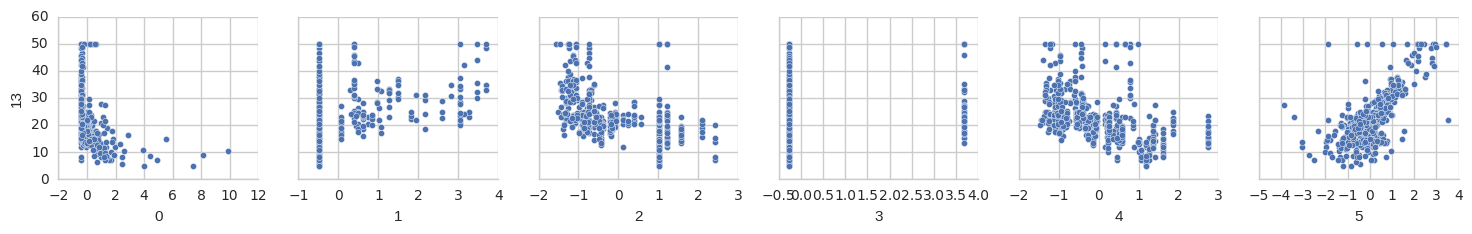

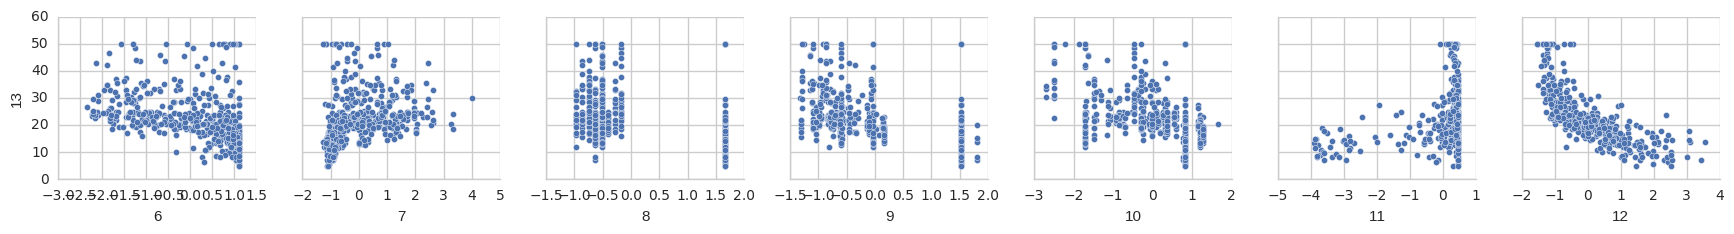

In [14]:
data = np.concatenate([X_std, y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(data)
sns.set(style='whitegrid', context='notebook')

# plot it separately for the ease of reading
# notice that '13' the the label.
sns.pairplot(df, x_vars=df.columns[0:int(X_std.shape[1]/2)], y_vars=df.columns[-1], size=2.5)
sns.pairplot(df, x_vars=df.columns[int(X_std.shape[1]/2):X_std.shape[1]], y_vars=df.columns[-1], size=2.5)

plt.tight_layout()
plt.savefig('./output/fig-pairwise-dist.png', dpi=300)
plt.show()
sns.reset_orig()


By observing the figure above, one will notice that some features might be useless, such as feature $3$ and $8$, since they are not seen to be related to the labels, while features like 5 and 12 have some obvious patterns.

And since most of the features have some patterns that related to our labels, I beleive that it is possible for us to learn things from this data set. Now, let us do some testing to support my assumption.

In [21]:
def mse_lr(model, X, y):
    return ((model.predict(X) - y)**2).mean()

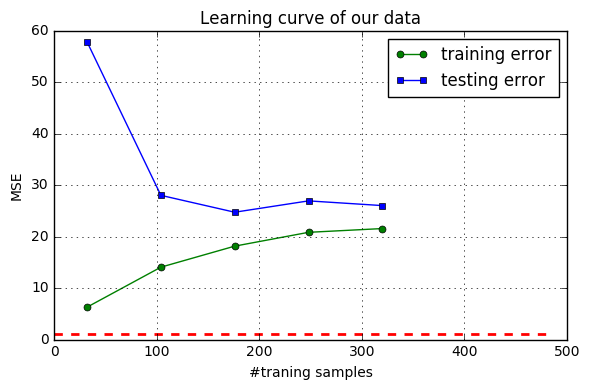

In [32]:
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import LinearRegression

test_set = np.loadtxt('X_test.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

num_data = X_std.shape[0]
lr = LinearRegression()

train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X_std, y=y_train, scoring=mse_lr)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='green', marker='o', markersize=5, label='training error')
plt.plot(train_sizes, test_mean, color='blue', marker='s', markersize=5, label='testing error')

plt.hlines(y=1, xmin=0, xmax=num_data, color='red', linewidth=2, linestyle='--')
plt.title('Learning curve of our data')
plt.grid()
plt.xlabel('#traning samples')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.savefig('./output/fig-learning-curve.png', dpi=300)
plt.show()

As the figure above shows, we can surely learn something with this data set. But, one thing we need to know is that if we just use this data to train our linear regressor without processing our data, we might be unable to reach a very low $MSE$, as you can see that the training and testing curve is converged at around 22-24 $MSE$. We will leave this problem to part III.

As for now, we can start tuning, since we've confirmed that the data is learnable.

### Tuning & Training
Our tasks in this section is to :
* tune $\eta$ and $\alpha$
* tune $\eta$ and $\alpha$ to **make $w$ sparse**

First, I will explain how I find $\eta$ and $\alpha$ to get a fine prediction result, and then I will show how I manage to tune an $\alpha$ such that the resulting weights $w$ will be sparse.

Now, let's do the first task. We have two hyper-parameters to tune: $\eta$ and $\alpha$. Before tuning alpha, we should first fine a proper $\eta$, and then find $\alpha$ by using fixed $\eta$.

In [50]:
etas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
max_iter = 30

for eta in etas:
    print('---- testing eta %.5f ----' % (eta))
    llr = LassoRegressor(eta=eta, n_iter=max_iter)
    llr = llr.fit(X_std, y_train)
    
    print(llr.cost_[-1])

---- testing eta 0.00001 ----
236.312021886
---- testing eta 0.00010 ----
56.5447983811
---- testing eta 0.00100 ----
36.7893688468
---- testing eta 0.01000 ----
Error! Sum of errors exceeds stop criteria
3.98381097927e+25
---- testing eta 0.10000 ----
Error! Sum of errors exceeds stop criteria
1.45385329969e+29


So, as the printed results show, 0.001 might be the best choice for us, since values below it might descent too slow, and values greater than it will cause overshooting, so the sum of errors will eventually exceed stop criteria.

Choosing $\eta=0.001$, we can start seaching for a proper $\alpha$ now. 

running with init alpha : 0.001
running with init alpha : 0.010
running with init alpha : 0.100
running with init alpha : 1.000
Finished searching alpha


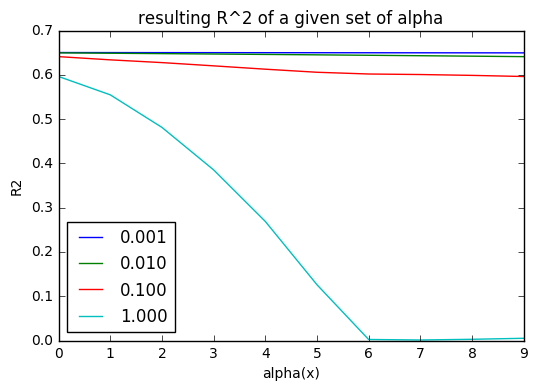

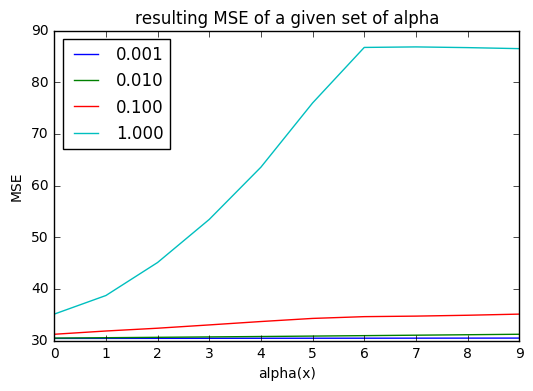

In [51]:
from sklearn.cross_validation import train_test_split

"""    
    We have learned that eta = 0.001 is our best choice,
    now let us find an appropriat alpha value
"""

a = 0.001
eta = 0.001
alphas = [0.001, 0.01, 0.1, 1]
max_iter = 5000

candidates = []
r2_lists = []
mse_lists = []
a_lists = []

for a in alphas:
    print("running with init alpha : %.3f" % (a))

    a_list = []
    r2_list = []
    mse_list = []
    inc = a
    for i in range(0, 10):
        # Examine the result of choosen alpha through training-validating process.
        X_tune_train, X_val, y_tune_train, y_val = train_test_split(
        X_std, y_train, test_size=0.4, random_state=1)

        llr = LassoRegressor(eta=eta, alpha=a, n_iter=max_iter)
        llr = llr.fit(X_tune_train, y_tune_train)
        
        y_val_pred = llr.predict(X_val)
        r2  = r2_score(y_val, y_val_pred)        
        mse = mean_squared_error(y_val, y_val_pred)
        
        a_list.append(a)
        r2_list.append(r2)
        mse_list.append(mse)
    
        a += inc
    # collect testing result
    a_lists.append(a_list)
    r2_lists.append(r2_list)
    mse_lists.append(mse_list)
    
print('Finished searching alpha')



a = 0.001
# now, we plot the resulting R^2 value of a given set of alpha values.
# each line in the figure indicates the resulting value of R^2 from 'a' to 'a * 9'
# (ex. if a = 0.001, then the line of 0.001 will be the R^2 value from 0.001 to 0.009)
for l in r2_lists:
    a_alpha = "%.3f" % a
    plt.plot(range(0,10), l, label=a_alpha)
    a *= 10

plt.title('resulting R^2 of a given set of alpha')
plt.ylabel('R2')
plt.xlabel('alpha(x)')
plt.legend(loc='best')
plt.savefig('./output/fig-alpha-plot-r2', dpi=300)
plt.show()


# same as above, but this time, we plot the MSE value.
a = 0.001
for l in mse_lists:
    a_alpha = "%.3f" % a
    plt.plot(range(0,10), l, label=a_alpha)
    a *= 10
    
plt.title('resulting MSE of a given set of alpha')
plt.ylabel('MSE')
plt.xlabel('alpha(x)')
plt.legend(loc='best')
plt.savefig('./output/fig-alpha-plot-mse', dpi=300)
plt.show()


As the figure shows above, if we want to have a good R^2/MSE results, we might need to pick a small $\alpha$. We will explain this later. Now let's compare our LassoRegressor with sklearn LinearRegressor

In [55]:

X_test = np.loadtxt('X_test.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

X_test = sc_x.transform(X_test)

olr = LinearRegression()
olr = olr.fit(X_std, y_train)

llr = LassoRegressor(alpha=0.001, n_iter=max_iter)
llr = llr.fit(X_std, y_train)

y_train_pred_o = olr.predict(X_std)
y_test_pred_o = olr.predict(X_test)

y_train_pred = llr.predict(X_std)
y_test_pred = llr.predict(X_test)


print("Ordinary least square regressor")
print(" R2 train: %.2f, test: %.2f" %(
        r2_score(y_train, y_train_pred_o), 
        r2_score(y_test, y_test_pred_o))
     )
print("MSE train: %.2f, test: %.2f" %(
        mean_squared_error(y_train, y_train_pred_o), 
        mean_squared_error(y_test, y_test_pred_o))   
    )

print("\nMy LassoRegressor")
print(" R2 train: %.2f, test: %.2f" %(
        r2_score(y_train, y_train_pred), 
        r2_score(y_test, y_test_pred))
     )
print("MSE train: %.2f, test: %.2f" %(
        mean_squared_error(y_train, y_train_pred), 
        mean_squared_error(y_test, y_test_pred))    
    )


Ordinary least square regressor
 R2 train: 0.74, test: 0.73
MSE train: 22.25, test: 15.81

My LassoRegressor
 R2 train: 0.73, test: 0.75
MSE train: 23.08, test: 14.84


It's good to know that our LassoRegressor works very well, and resulting in a little bit higher $R^2$ and $MSE$ result in test set. But the werid thing is: our regressor does not do any better than sklearn in the training phase. 

So why did it can surpass the scikit-Linear regressor(ordinary least square regressor)? One possible reason is that the testing data is too small, and the testing data may just happen to match the pattern our regressor has learned. Once the testing data become bigger and bigger, the scikit one may eventually surpass our regressor.


### Tuning $\alpha$ to make $w$ sparse
Now, we have to tune the $\alpha$ to make $w$ sparse.

In [56]:

def plot_compress(coef, max_alpha, title='LassoRegressor'):
    """ A helper function that help us plot our coefficients(weights)
    
    Parameters
    ----------
    coef : ndarray
           List of coefficients(weights) with respects to some alpha value.
    max_alpha : int
           Maximum alpha value.
    title : str
           The title of resulting figure.
    
    """
    
    plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

    for i in range(coef.shape[1]):
        plt.plot(range(max_alpha),coef[:,i])
    
    plt.title(title)
    plt.ylabel('Coefficients')
    plt.xlabel('Alpha')
    plt.tight_layout()
    plt.savefig('./output/fig-%s-decay.png' % title, dpi=300)
    plt.show()


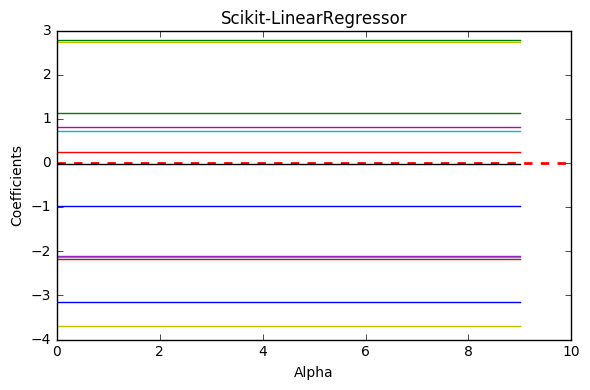

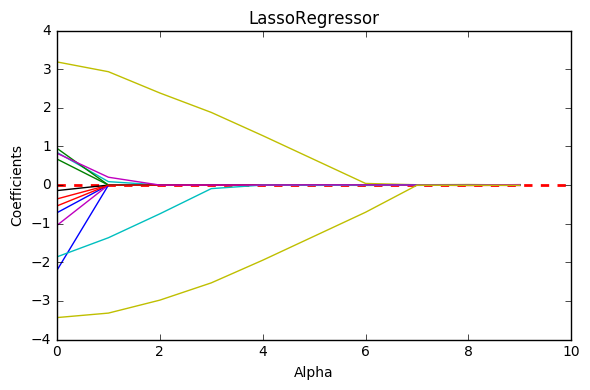

In [59]:
max_alpha = 10

coef_lr  = np.zeros((max_alpha, X_std.shape[1]))
coef_llr = np.zeros((max_alpha, X_std.shape[1]))

for a in range(max_alpha):
    lr = LinearRegression()
    lr.fit(X_std, y_train)
    
    llr = LassoRegressor(alpha=a, n_iter=max_iter)
    llr.fit(X_std, y_train)
    
    coef_lr[a,:] = lr.coef_.reshape(1, -1)
    coef_llr[a,:] = llr.w_[1:].reshape(1, -1)

plot_compress(coef_lr, max_alpha, title='Scikit-LinearRegressor')
plot_compress(coef_llr, max_alpha)

Ordinary least square regressor will just simply compute:
$$min_{w}\Vert Xw - y\Vert_{2}^{2}$$

So it's not surprise to have a flat $w$.

However, the $\alpha$ term will work as a compressor in **LassoRegressor** : The larger the $\alpha$, the smaller the coefficients, and **the less useful a feature is, the faster it will be compressed to zero**. 

And in our LassoRegressor, the $w$ will be become sparse will $\alpha$ is closed to 1, and will have only 2 featues left when $\alpha=2$.

This figure can also explain when $R^2$ and $MSE$ escalated quick when we picking a $\alpha$ larger than 1. When $\alpha$ reaches 1, many of the weights have been pressed to zero, that is, some possibly useful features might be eliminated from the regressor. and when $\alpha$ gets to 6, all the weights have been pressed to zero, which means that the regressor make prediction based on **only on bias, since other features have been totally eliminated**.

So if you check the figure of $MSE$ and $R^2$, you will find that $R^2$ reaches 0.0 and the curve of $MSE$ is flatten after setting $\alpha=6$



### Conclusion

In this section, we have found that:
* $\eta=0.001$ with $\alpha=0.001$ can make our regressor work well
* when $\alpha$ reaches 1, it will start becoming sparse

# Part III. Feature Selecetion and XRegressor

### Quick summary 
* Best $\overline{R}^2$ : $0.75$ (using 3 features)

Feature #6 : 0.18538
Feature #13 : -0.18139
Feature #11 : -0.11826
Feature #3 : -0.09587
Feature #5 : -0.08630
Feature #10 : -0.07531
Feature #1 : -0.05629
Feature #7 : -0.05295
Feature #9 : -0.04917
Feature #2 : 0.04856
Feature #12 : 0.03804
Feature #8 : 0.00329
Feature #4 : 0.00144


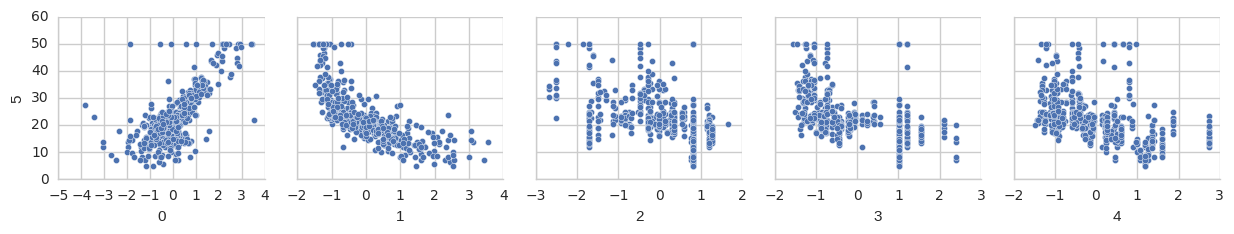

In [60]:
llr = LassoRegressor(alpha=2)
llr = llr.fit(X_std, y_train)
feat = np.argsort(np.fabs(llr.w_[1:]))[::-1]

for i in range(len(llr.w_[1:])):
    print("Feature #%d : %.5f" %(feat[i]+1, llr.w_[feat[i]+1]))

n_sel = 5
selected = feat[0:n_sel]
selected_data = np.concatenate([X_std[:, selected], y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(selected_data)
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[0:n_sel], y_vars=df.columns[-1], size=2.5)
plt.tight_layout()
plt.savefig('./output/fig-feat-pairwise-dist.png', dpi=300)
plt.show()
sns.reset_orig()


In [61]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

class XRegressor(object):
    """
        A lasso regressor that uses coordinate descent as a descent method
    """
    def __init__(self, alpha=0.001, n_iter=40, random_state=1, zero=1e-10):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.zero = zero
        self.random_state = random_state
        
    def fit(self, X, y, n_e_iter=3000, n_alpha=2, n_feat=5, 
                        extract_feats=False, remove_outlier=False, ro_thresh=4.0, stop_crit=1e+15):
        
        if extract_feats:
            X = self.extract_feats_(X, y, alpha=n_alpha, n_iter=n_e_iter, n_feat=n_feat)
        
        if remove_outlier:
            X, y = self.ransac_feats_(X, y, ro_thresh)
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        N = X.shape[0]
        norm_X = (X**2).sum(axis=0)
        
        # notes that self.w_[0] is the intercept term
        # The concept of Coordinate Descent is that we find min of x_j
        # "ONE AT A TIME." Doing it simultaneously won't work at all.
        # and since Coordinate descent is "derivative free", we need no
        # gradient this time!
        
        for i in range(self.n_iter):
            for j in range(1, len(self.w_)):
                # We need to compute each x_j independently, so we should
                # first set the "influence" of x_j to zero.
                r_resp = self.predict(X, ignore=j)
                # partial residual
                pr = y - r_resp
                # residual predictor
                r_pred = X[:, j-1].dot(pr).sum()
                self.w_[j] = self.soft_threshold_(r_pred, N) / norm_X[j-1]
            output = self.predict(X)
            errors = y - output

            L1_norm = np.abs(self.w_[1:]).sum()
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / (2.0 * N) + self.alpha * L1_norm
            self.cost_.append(cost)
            
            
            if errors.sum() >= stop_crit:
                print("Error! Sum of errors exceeds stop criteria")
                break
        
        return self
    
    def soft_threshold_(self, r_pred, N):
        if np.fabs(r_pred) < (self.alpha * N):
            return 0
        return np.sign(r_pred) * (np.fabs(r_pred) - (self.alpha * N))
    
    def extract_feats_(self, X, y, alpha, n_iter, n_feat):
        llr = LassoRegressor(alpha=alpha, n_iter=n_iter)
        llr = llr.fit(X, y)
        feat = np.argsort(np.fabs(llr.w_[1:]))[::-1]
        self.selected = feat[0:n_feat]
        
        return X[:, self.selected]
    
    def ransac_feats_(self, X, y, thresh):
        ransac = RANSACRegressor(LinearRegression(), 
                max_trials=100, 
                min_samples=50, 
                residual_threshold=thresh, 
                random_state=0)
        ransac.fit(X, y)
                   
        inlier = ransac.inlier_mask_
        X_filt = X[inlier, :]
        y_filt = y[inlier]
        return X_filt, y_filt
    
    def predict(self, X, ignore=None):
        # for x^0 to x^n 
        if ignore == None:
            return np.dot(X, self.w_[1:]) + self.w_[0]
        
        ign_ = deepcopy(self.w_[1:])
        ign_[ignore-1] = 0
        
        return np.dot(X, ign_) + self.w_[0]
    

In [62]:
def r2_bar_score(y, y_pred, N, P):
    return 1 - ((((y - y_pred)**2).sum()) / (N - P - 1)) / ((((y - np.mean(y))**2).sum()) / (N - 1))


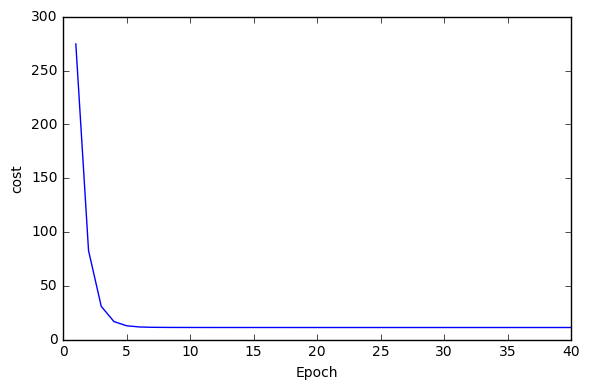

MSE train: 22.25
R^2 train: 0.74


In [63]:
train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

sc_x = StandardScaler()
X_std = sc_x.fit_transform(train_set)

xr = XRegressor()
xr = xr.fit(X_std, y_train, extract_feats=False)

plt.plot(range(1, xr.n_iter+1), xr.cost_)
plt.ylabel('cost')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('./output/fig-lasso-cost.png', dpi=300)
plt.show()

y_train_pred = xr.predict(X_std)
print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('R^2 train: %.2f' % (r2_score(y_train, y_train_pred)))


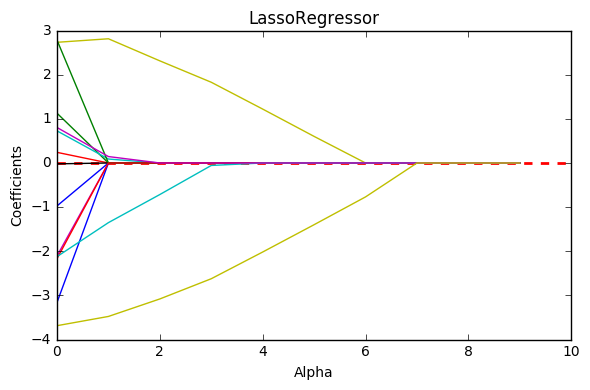

In [64]:
max_alpha = 10
coef = np.zeros((max_alpha, X_std.shape[1]))

for a in range(max_alpha):
    xr = XRegressor(alpha=a, n_iter=max_iter)
    xr.fit(X_std, y_train)
    coef[a,:] = xr.w_[1:].reshape(1, -1)
    
plot_compress(coef, max_alpha)

In [65]:
def print_train_val(y_train_pred, y_train, y_valid_pred, y_valid, train_size, valid_size, P):
    print("      Training R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
        r2_bar_score(y_train, y_train_pred, train_size, P),
        r2_score(y_train, y_train_pred),
        mean_squared_error(y_train, y_train_pred)
    ))
    
    print("    Validating R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
        r2_bar_score(y_valid, y_valid_pred, valid_size, P),
        r2_score(y_valid, y_valid_pred),
        mean_squared_error(y_valid, y_valid_pred)
    ))


In [66]:
train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')
X_std = sc_x.fit_transform(train_set)

max_feats = 5
mse_best = 100
r2b_best = 0
for i in range(1, max_feats+1):
    sc_x = StandardScaler()

    X_tune_train, X_valid, y_tune_train, y_valid = train_test_split(
        X_std, y_train, test_size=0.5, random_state=0)
    
    xr = XRegressor(alpha=0.001, n_iter=max_iter)
    xr = xr.fit(X_tune_train, y_tune_train, n_feat=i, extract_feats=True)

    y_train_pred = xr.predict(X_tune_train[:, xr.selected])
    y_valid_pred = xr.predict(X_valid[:, xr.selected])
    print("=== %d features ===" %(i))
    print("Selected : %s" %(xr.selected))
    print("Coordinate Descent")
    print_train_val(y_train_pred, y_tune_train, y_valid_pred, y_valid,
                    X_tune_train.shape[0], X_valid.shape[0], xr.w_.shape[0]-1)

    
    llr = LassoRegressor(alpha=0.001, n_iter=max_iter)
    llr = llr.fit(X_tune_train[:, xr.selected], y_tune_train)

    y_train_pred = llr.predict(X_tune_train[:, xr.selected])
    y_valid_pred = llr.predict(X_valid[:, xr.selected])
    
    print("Subgradient Descent")
    print_train_val(y_train_pred, y_tune_train, y_valid_pred, y_valid,
                    X_tune_train.shape[0], X_valid.shape[0], llr.w_.shape[0]-1)

    
    

=== 1 features ===
Selected : [12]
Coordinate Descent
      Training R2_bar: 0.53, R2: 0.53, MSE: 40.79
    Validating R2_bar: 0.54, R2: 0.54, MSE: 38.71
Subgradient Descent
      Training R2_bar: 0.53, R2: 0.53, MSE: 40.79
    Validating R2_bar: 0.54, R2: 0.54, MSE: 38.74
=== 2 features ===
Selected : [12  5]
Coordinate Descent
      Training R2_bar: 0.60, R2: 0.60, MSE: 34.70
    Validating R2_bar: 0.66, R2: 0.66, MSE: 28.31
Subgradient Descent
      Training R2_bar: 0.60, R2: 0.60, MSE: 34.71
    Validating R2_bar: 0.66, R2: 0.66, MSE: 28.19
=== 3 features ===
Selected : [12  5 10]
Coordinate Descent
      Training R2_bar: 0.63, R2: 0.64, MSE: 31.67
    Validating R2_bar: 0.70, R2: 0.71, MSE: 24.62
Subgradient Descent
      Training R2_bar: 0.63, R2: 0.64, MSE: 31.68
    Validating R2_bar: 0.70, R2: 0.71, MSE: 24.51
=== 4 features ===
Selected : [12  5 10  0]
Coordinate Descent
      Training R2_bar: 0.64, R2: 0.65, MSE: 30.87
    Validating R2_bar: 0.70, R2: 0.70, MSE: 25.09
Subgra

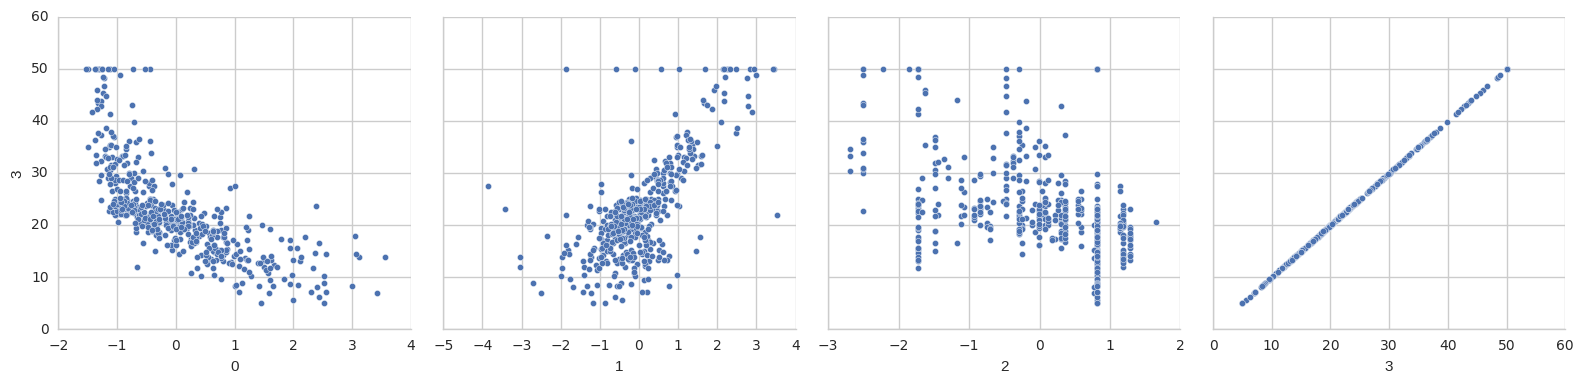

In [67]:

xr = XRegressor(alpha=0.001, n_iter=max_iter)
xr = xr.fit(X_std, y_train, n_feat=3, extract_feats=True)

selected = xr.selected

data = np.concatenate([X_std[:, selected], y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(data)
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[0:X_std[:,selected].shape[0]], y_vars=df.columns[-1], size=4)

plt.tight_layout()
plt.savefig('./output/fig-selected-3feats', dpi=300)
plt.show()
sns.reset_orig()




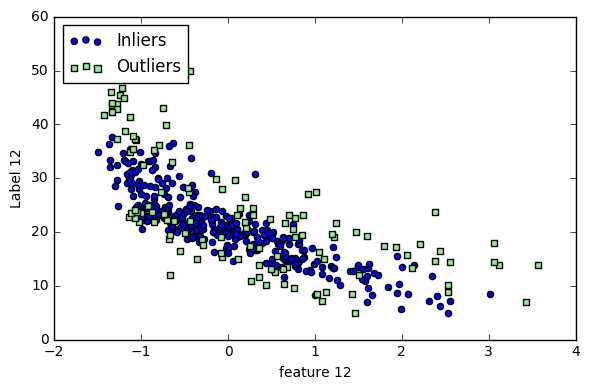

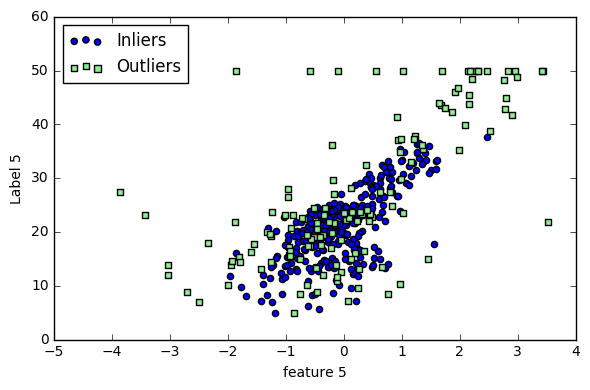

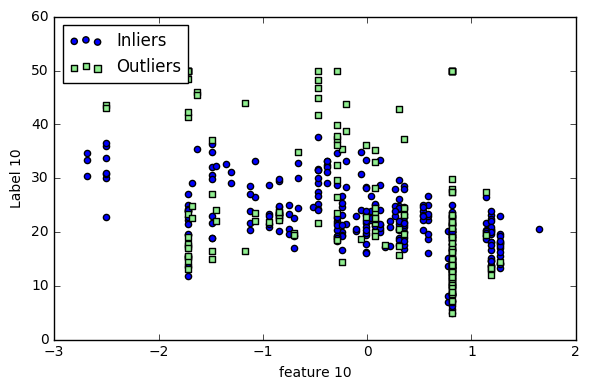

In [68]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

ransac = RANSACRegressor(LinearRegression(), 
            max_trials=100, 
            min_samples=50, 
            residual_threshold=4.0, 
            random_state=0)

ransac.fit(X_std[:, selected], y_train)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
for i in selected:
    X_sel = X_std[:, [i]]
    line_X = np.arange(-4, 5, 1)
    #line_y_ransac = ransac.predict(line_X[:, np.newaxis])
    plt.scatter(X_sel[inlier_mask], y_train[inlier_mask], 
                c='blue', marker='o', label='Inliers')
    plt.scatter(X_sel[outlier_mask], y_train[outlier_mask],
                c='lightgreen', marker='s', label='Outliers')
    #plt.plot(line_X, line_y_ransac, color='red')
    plt.xlabel('feature %d' %(i))
    plt.ylabel('Label %d' %(i))
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()  


In [99]:
xr = XRegressor(alpha=0.001, n_iter=max_iter)
xr = xr.fit(X_std, y_train, n_feat=3, extract_feats=True, remove_outlier=True, ro_thresh=4.0)

y_test_pred = xr.predict(X_test[:, xr.selected])

print("XRegresso(filtered) Testing R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
    r2_bar_score(y_test, y_test_pred, X_test.shape[0], xr.w_.shape[0]-1),
    r2_score(y_test, y_test_pred),
    mean_squared_error(y_test, y_test_pred)
    ))
selected = xr.selected



XRegresso(filtered) Testing R2_bar: 0.75, R2: 0.78, MSE: 13.00


In [102]:
from sklearn.preprocessing import PolynomialFeatures


ds = [1, 2, 3]

for d in ds:
    poly = PolynomialFeatures(degree=d)
    X = poly.fit_transform(X_std[:, selected])
    
    X_tune_train, X_valid, y_tune_train, y_valid = train_test_split(
        X, y_train, test_size=0.5, random_state=0)
    
    xr = XRegressor(alpha=0.001, n_iter=max_iter)
    xr = xr.fit(X_tune_train, y_tune_train)
    
    y_train_pred = xr.predict(X_tune_train)
    y_valid_pred = xr.predict(X_valid)

    print(" Train-Val with degree %d (%d features)" %(d, X_tune_train.shape[1]))
    print_train_val(y_train_pred, y_tune_train, y_valid_pred, y_valid,
                    X_tune_train.shape[0], X_valid.shape[0], xr.w_.shape[0]-1)


 Train-Val with degree 1 (4 features)
      Training R2_bar: 0.63, R2: 0.64, MSE: 31.67
    Validating R2_bar: 0.70, R2: 0.71, MSE: 24.62
 Train-Val with degree 2 (10 features)
      Training R2_bar: 0.76, R2: 0.77, MSE: 20.03
    Validating R2_bar: 0.81, R2: 0.81, MSE: 15.60
 Train-Val with degree 3 (20 features)
      Training R2_bar: 0.76, R2: 0.78, MSE: 18.79
    Validating R2_bar: 0.76, R2: 0.78, MSE: 18.24


In [101]:
poly = PolynomialFeatures(degree=2)

X = poly.fit_transform(X_std[:, selected])
X_poly_test = poly.transform(X_test[:, selected])

xr = XRegressor(alpha=0.001, n_iter=max_iter)
xr.fit(X, y_train)

y_test_pred = xr.predict(X_poly_test)

print("XRegresso(filtered) Testing R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
    r2_bar_score(y_test, y_test_pred, X_poly_test.shape[0], xr.w_.shape[0]-1),
    r2_score(y_test, y_test_pred),
    mean_squared_error(y_test, y_test_pred)
    ))

XRegresso(filtered) Testing R2_bar: 0.73, R2: 0.84, MSE: 9.27
